In [1]:
#%matplotlib notebook
import os
import numpy as np
import random
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import call
from sklearn.neighbors.kde import KernelDensity
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
import pandas as pd
sns.set(color_codes=True)
from utilities import *
from skimage.morphology import remove_small_objects

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian
import statsmodels.api as sm
from scipy import ndimage as ndi


# path for the training set directory
stage1_dataset_path = '/Users/jonathansaragosti/Documents/GitHub/Python/Kaggle/2018 Data Science Bowl/science_bowl/data/stage1_train/'
# Check how many images there are in total in the training set
dataset = DataSet(stage1_dataset_path, data_set_type='train')


/Users/jonathansaragosti/miniconda3/envs/sciencebowl/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Image is inverted


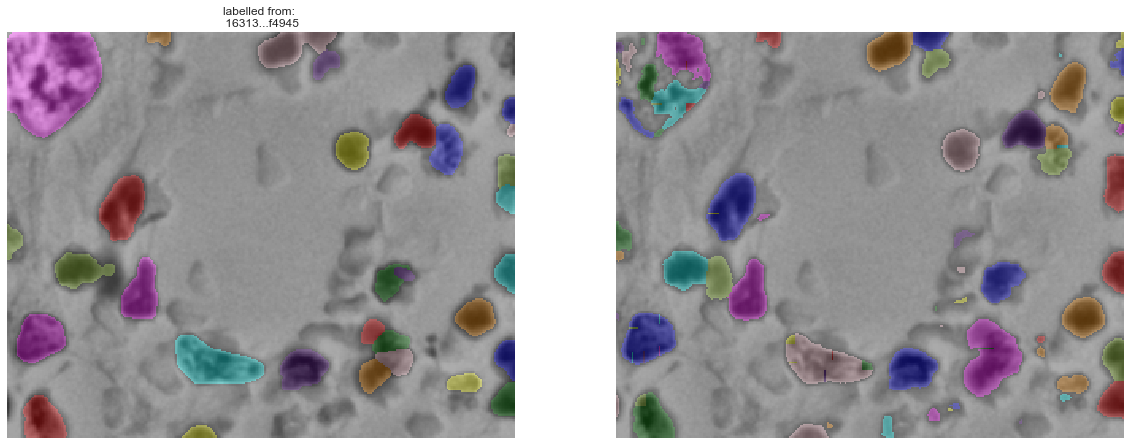

In [2]:
n = 578 #random.choice(range(len(dataset.subdir)))
w_props, labels, lbl_img = dataset.subdir[n].get_watershed_props()
if dataset.subdir[n].image.is_inverted:
    print('Image is inverted')
plt.figure(figsize=(20,10))
plt.subplot(121)
dataset.subdir[n].show_labelled_img(src='masks')
plt.subplot(122)
plt.imshow(lbl_img)
plt.xticks([])
plt.yticks([])
plt.show()




In [15]:
n

578

In [11]:
def compare_methods(dataset,n,methods):
    columns = (len(methods)+1)
    fig_unit = 5
    fig_size = (fig_unit*columns,fig_unit*2)
    print(fig_size)
    plt.figure(figsize=fig_size)
    
    plt.subplot(2, columns, 1)
    dataset.subdir[n].show_labelled_img(src='masks')
    plt.subplot(2, columns, columns+1)
    dataset.subdir[n].show_full_mask(src='masks')
    cnt = 1
    for method in methods:
        cnt += 1
        plt.subplot(2, columns, cnt)
        dataset.subdir[n].show_labelled_img(src='segmentation', method=method)
        plt.title(method)
        plt.subplot(2, columns, columns+cnt)
        dataset.subdir[n].show_full_mask(src='segmentation', method=method)
        plt.title(method)
    print(dataset.subdir[n].image.id)
    plt.show()

    

In [32]:
#n = random.choice(range(len(dataset.subdir)))
n = 101

In [31]:
print(n)


In [ ]:


compare_methods(dataset,n,['otsu', 'yen','isodata'])
compare_methods(dataset,n,['otsu', 'li','minimum'])


In [ ]:
import cv2

mser = cv2.MSER_create()
img = dataset.subdir[n].image.eq_img()

vis = img.copy()
regions, _ = mser.detectRegions(img)
len(regions)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]


cv2.polylines(vis, hulls, 1, (0, 255, 0))
mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)

for contour in hulls:
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

#this is used to find only text regions, remaining are ignored
text_only = cv2.bitwise_and(img, img, mask=mask)
text_only.shape
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

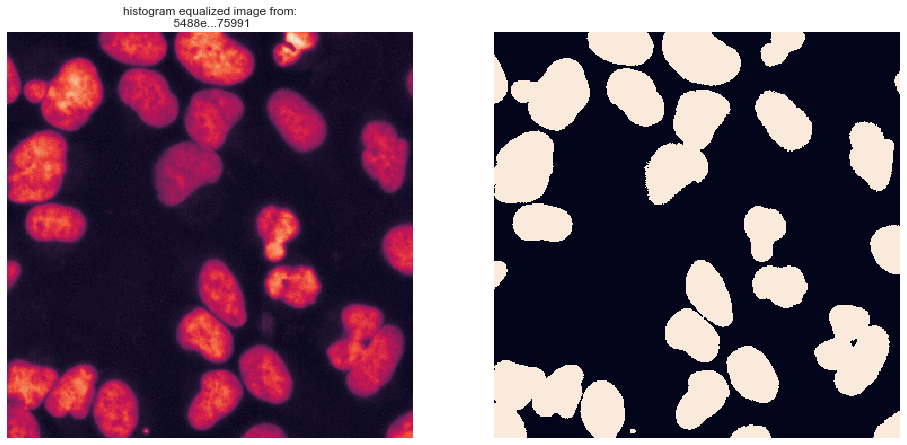

In [10]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
dataset.subdir[n].image.show(eq=True)
plt.subplot(1,2,2)
plt.imshow(dataset.subdir[n].get_full_mask(delta=0))
plt.xticks([])
plt.yticks([])
plt.show()


## find typical size of nuclei

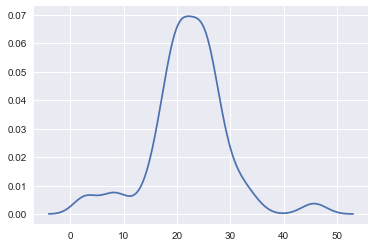

typical blob size is 22 pixels


In [7]:
n=101
# get segmented image
image = dataset.subdir[n].get_full_mask(src='segmentation', method='otsu')
# get connected components
props, label_img = dataset.subdir[n].get_props()
# get kde for area
dens = sm.nonparametric.KDEUnivariate([float(prop.minor_axis_length) for prop in props])
dens.fit()
plt.plot(dens.support,dens.density)
plt.show()
blob_size = dens.support[dens.density.argmax()]
print('typical blob size is {:.0f} pixels'.format(blob_size))

### Use watershed to separate nuclei	


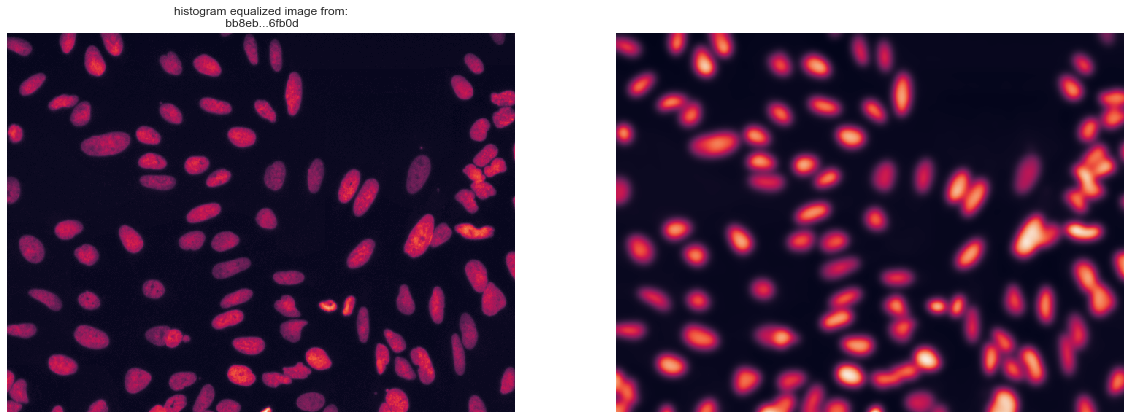

In [8]:
filtered = gaussian(dataset.subdir[n].image.eq_img(), sigma=blob_size/4)


plt.figure(figsize=(20,10))
plt.subplot(121)
dataset.subdir[n].image.show(eq=True)
plt.subplot(122)
plt.imshow(filtered)
plt.xticks([])
plt.yticks([])
plt.show()


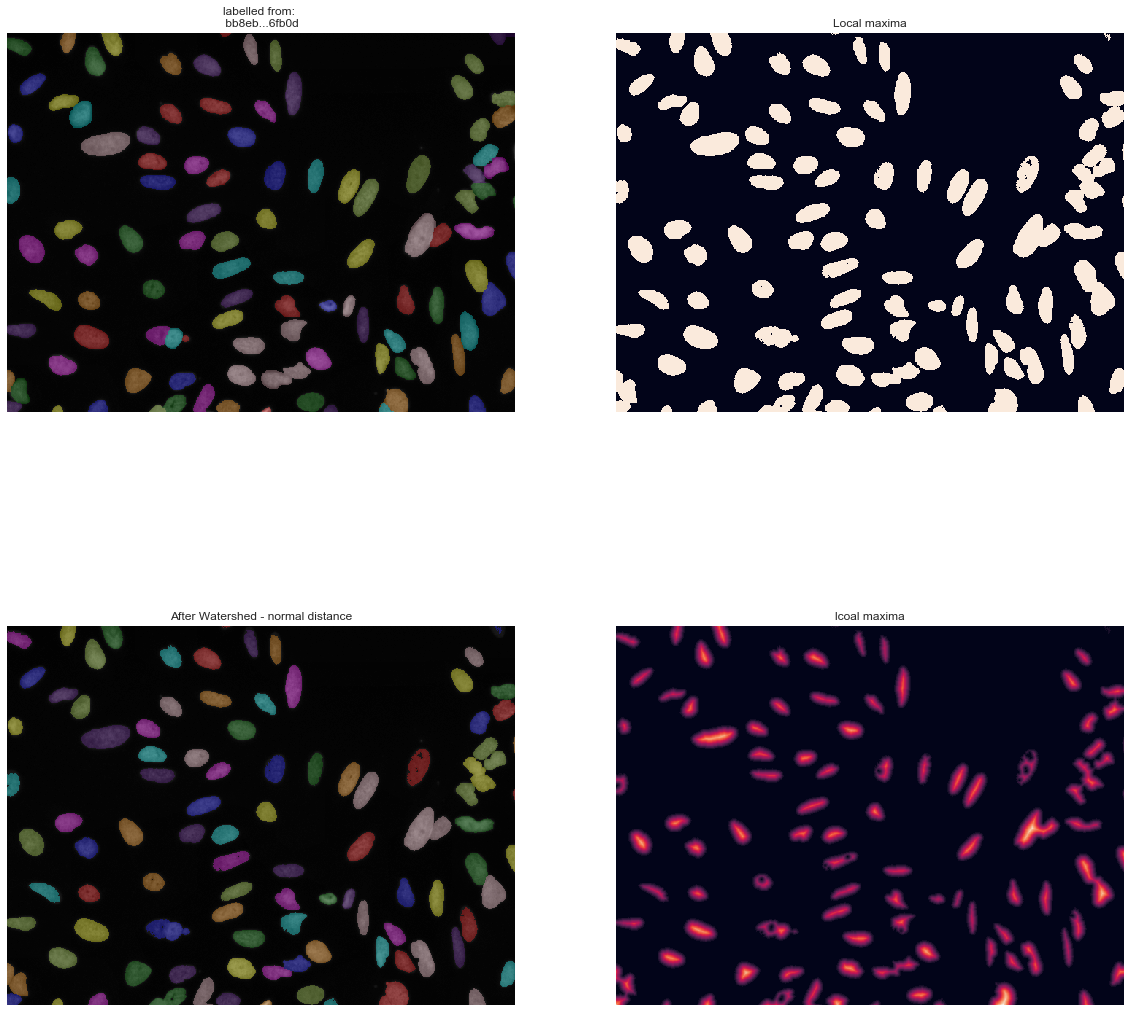

In [9]:
# compute distance transform 
#distance = ndi.distance_transform_edt(filtered*dataset.subdir[n].get_full_mask()) #ORIGINAL
distance = ndi.distance_transform_edt(dataset.subdir[n].get_full_mask())


#tot_area = sum([float(prop.area) for prop in props])
#dens = sm.nonparametric.KDEUnivariate([float(prop.area) for prop in props])
#dens.fit()

#blob_area = dens.support[dens.density.argmax()]
#num_peaks = int(tot_area/blob_area)


local_maxi = peak_local_max(
    filtered,
    min_distance=blob_size/2,
    exclude_border=0,
    indices=False,
#    threshold_rel= 0.8,
    #footprint=np.ones((3, 3)),
    labels=dataset.subdir[n].get_label_img(src='segmentation'),
    num_peaks_per_label=10,
    #num_peaks=num_peaks*1.2,
    )
markers = ndi.label(local_maxi)[0]
labels_0 = watershed(-distance, markers, mask=dataset.subdir[n].get_full_mask())
image_label_overlay_0 = label2rgb(labels_0, image=dataset.subdir[n].image.eq_img(), bg_label=0)

plt.figure(figsize=(20, 20))
plt.subplot(221)
dataset.subdir[n].show_labelled_img(src='masks')
plt.subplot(222)
plt.imshow(dataset.subdir[n].get_full_mask())
plt.title('Local maxima')
plt.xticks([])
plt.yticks([])
plt.subplot(223)
plt.imshow(image_label_overlay_0)
plt.title('After Watershed - normal distance')
plt.xticks([])
plt.yticks([])
plt.subplot(224)
plt.imshow(distance)
plt.title('lcoal maxima')
plt.xticks([])
plt.yticks([])
plt.show()


AttributeError: 'SubDir' object has no attribute 'get_watershed_props'

AttributeError: 'SubDir' object has no attribute 'get_watershed_props'

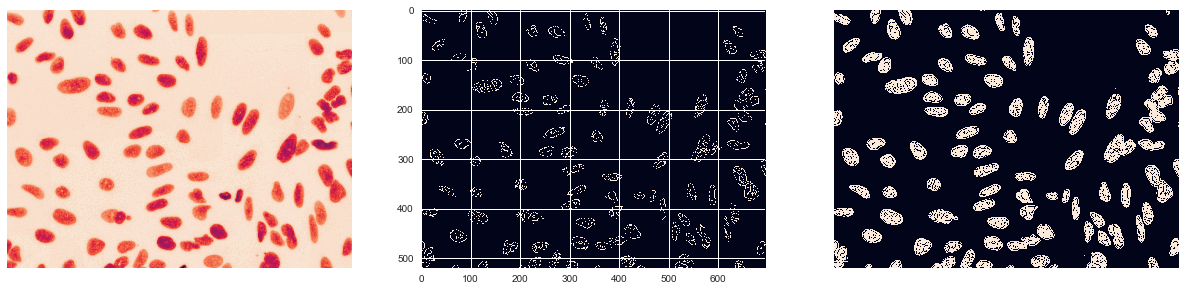

In [35]:
from skimage.feature import canny
image = dataset.subdir[n].get_full_mask(src='segmentation', method='otsu')
can = canny(
        255-dataset.subdir[n].image.eq_img(),
        sigma=2, low_threshold=0.3, high_threshold=0.2,
        mask=dataset.subdir[n].get_full_mask(src='segmentation', method='otsu'),
        use_quantiles=False
    )
plt.figure(figsize=(21,8))
plt.subplot(1,3,1)
plt.imshow(255-dataset.subdir[n].image.eq_img())
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(can)#np.bitwise_xor(dataset.subdir[n].get_full_mask(src='segmentation', method='otsu'),can))
plt.subplot(1,3,3)
plt.imshow(np.bitwise_xor(dataset.subdir[n].get_full_mask(src='segmentation', method='otsu'),can))

plt.xticks([])
plt.yticks([])
plt.show()


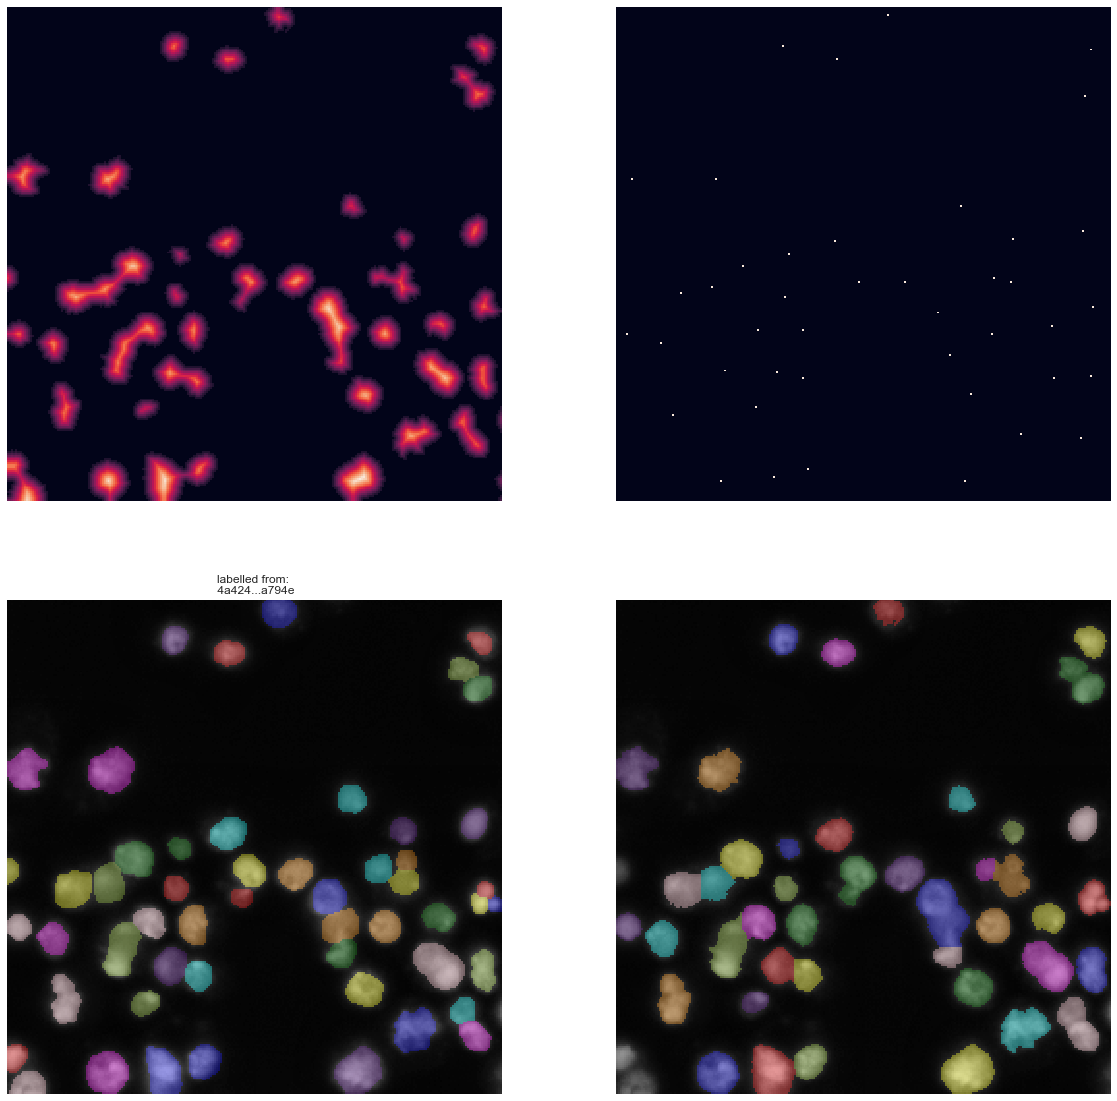

In [208]:
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

result = hough_ellipse(can, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

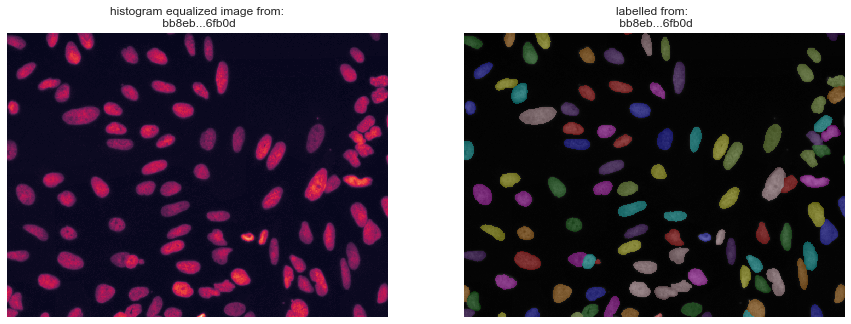

In [34]:

plt.figure(figsize=(15,30))
plt.subplot(121)
dataset.subdir[n].image.show(eq=True)
plt.subplot(122)
dataset.subdir[n].show_labelled_img(src='masks')
plt.show()


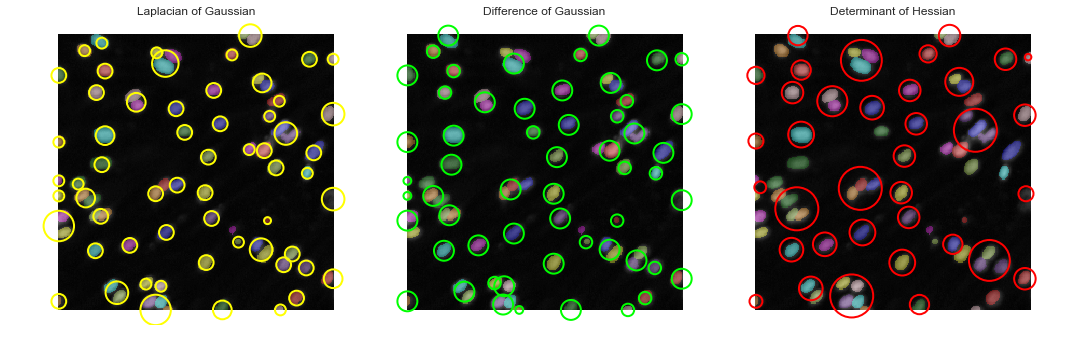

In [171]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


#image = data.hubble_deep_field()[0:500, 0:500]
image_gray = dataset.subdir[n].image.eq_img()

blobs_log = blob_log(image_gray, max_sigma=10, num_sigma=8, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=10, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(
        image_gray,
        min_sigma=0.5,
        max_sigma=20,
        num_sigma=40,
        threshold=0.002,
        overlap=0.1,
    )


blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian','Determinant of Hessian']
          
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, len(blobs_list), figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(dataset.subdir[n].get_overlay(src='masks'), interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()


In [156]:
blobs_doh

array([[247.        ,  83.        ,   7.44444444],
       [106.        , 190.        ,   7.44444444],
       [ 90.        , 210.        ,  13.88888889],
       [ 32.        ,  42.        ,   7.44444444]])

In [ ]:
# path for the training set directory
stage1_test_path = '/Users/jonathansaragosti/Documents/GitHub/Python/Kaggle/2018 Data Science Bowl/nuclei/data/stage1_test/'
# Check how many images there are in total in the training set
dataset = DataSet(stage1_test_path, data_set_type='test')

## ----------------------------------------------------------


f = open("third_submission.csv","w")
f.write("ImageId,EncodedPixels\n")
cnt = 0
for subdir in dataset.subdir:
    f.write(subdir.rle_str(add_watershed=True)) 
 
f.close() 


In [21]:
test = 2
if test is None:
    print('yo')